In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import LCHS
import kvn

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

20250
/media/work/docs/codes/QuCF/scripts-py


In [2]:
path_save_ = "./jupyter-notebooks/NL/results/"
for i in range(30):
    plt.close()

In [3]:
# -----------------------------------------------------------------------
# --- Periodic boundary conditions ---
# -----------------------------------------------------------------------
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
# matplotlib.rc('axes', linewidth=2)
# matplotlib.rc('font', weight='bold')

def der_first(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - y[ii-1]
        else:
            y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der
# -----------------------------------------------------------------------
def der_second(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - 2. * y[ii] + y[ii - 1]
        else:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[ii - 1]
    y_der /= (dx**2)
    return y_der
# -----------------------------------------------------------------------
def plot_tx(x, t, y, flag_simple=True):
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    cmap_two_signs_= 'coolwarm'
    if flag_simple:
        fontsize = 16

        XX, YY = np.meshgrid(t, x)
        fig_tx = plt.figure(figsize=(8, 6))
        ax = fig_tx.add_subplot(111)
        cs = ax.contourf(
            XX, YY, np.transpose(y), 
            levels=100, cmap=cmap_two_signs_, norm=divnorm
        )
        cb = fig_tx.colorbar(cs, ax = ax)
        cb.ax.ticklabel_format(style="scientific")
        cb.ax.tick_params(labelsize=fontsize) 
        ax.set_xlabel('$t$', fontsize = fontsize)
        ax.set_ylabel('$x$', fontsize = fontsize)
        ax.set_title('$y(t,x)$', fontsize = fontsize)
        ax.set_xlim(0, np.max(t))
        ax.set_ylim(0, np.max(x))
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
    else:
        fontsize = 30
        coef_labels = 1.2

        XX, YY = np.meshgrid(t, x)
        fig_tx = plt.figure(figsize=(14, 10))
        ax = fig_tx.add_subplot(111)
        cs = ax.contourf(
            XX, YY, np.transpose(y), 
            levels=100, cmap=cmap_two_signs_, norm=divnorm
        )
        cb = fig_tx.colorbar(cs, ax = ax)
        cb.ax.ticklabel_format(style="scientific")
        cb.ax.tick_params(labelsize=fontsize) 
        ax.set_xlabel('$t$', fontsize = coef_labels*fontsize)
        ax.set_ylabel('$s$', fontsize = coef_labels*fontsize)
        ax.set_title('$\psi(t,s)$', fontsize = coef_labels*fontsize)
        ax.set_xlim(0, np.max(t))
        ax.set_ylim(0, np.max(x))
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
    return

v	 1.0
D	 1.0e-02
Nx	 64
Nt	 4096
--- Stability criteria ---
current dx, dt:	 1.587e-02, 4.884e-04
maximum dx, dt:	 2.000e-02, 1.260e-02
Courant number: 0.0308


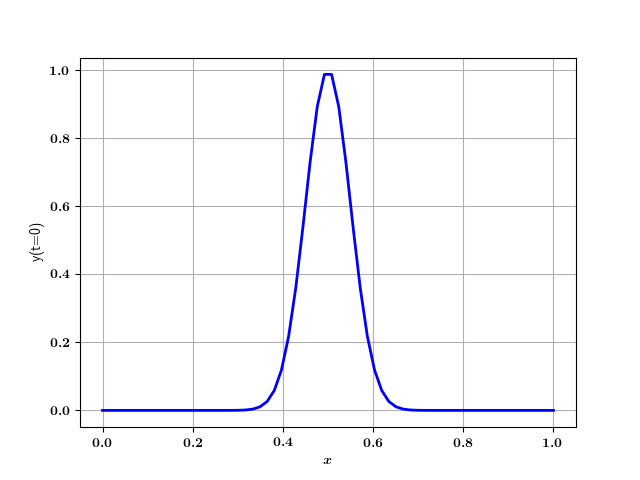

spectral norm.: 1.588e+02
Matrix Ah:	 nonsparsity, coefnorm: 3, 2.917e+02
Matrix Aa:	 nonsparsity, coefnorm: 2, 8.910e+01
Aa.Ah - Ah.Aa: 0.000e+00+2.252e-13j


In [4]:
# ---------------------------------------------------------------------
# --- Diffusion-Advection equation ---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(LCHS)

flag_RG = True
flag_init_sin = False

nx, nt = 6, 12
xmax, tmax = 1.0, 2.0
v = 1.0
D = 0.01

# --- Grids ---
Nx = 1 << nx
Nt = 1 << nt
x = np.linspace(0, xmax, Nx)
t = np.linspace(0, tmax, Nt)
dt = np.diff(t)[0]
dx = np.diff(x)[0]

print("v\t {:0.1f}".format(v))
print("D\t {:0.1e}".format(D))
print("Nx\t {:d}".format(Nx))
print("Nt\t {:d}".format(Nt))

print("--- Stability criteria ---")
dx_max = 2. * D / v
dt_max = dx**2 / (2. * D)
print("current dx, dt:\t {:0.3e}, {:0.3e}".format(dx, dt))
print("maximum dx, dt:\t {:0.3e}, {:0.3e}".format(dx_max, dt_max))
print("Courant number: {:0.3}".format(v * dt/ dx))

# --- signal ---
y = np.zeros((Nt, Nx))

# --- initial condition ---
Lw = 0.5*xmax
kw = 2.*np.pi / Lw

width_init = None
if flag_init_sin:
    y[0,:] = np.sin(kw * x)
else:
    width_init = 0.05
    y[0,:] = np.exp( - (x - xmax/2.)**2/(2. * width_init**2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y[0, :], color='blue', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
plt.ylabel("y(t=0)")
plt.grid(True)
plt.show()

# --------------------------------------------------------
# --- Form the matrix for the DC equation ---
# --------------------------------------------------------
def get_A_DC():
    A = np.zeros((Nx, Nx))
    beta = 1. / (dx**2)
    sigma = 1. / (2.*dx)
    coef_r = D * beta - v * sigma
    coef_c = -2. * D * beta
    coef_l = D * beta + v * sigma
    for ir in range(Nx):
        ic_l = ir - 1
        ic_r = ir + 1
        if ir == 0:
            ic_l = Nx - 1
        if ir == (Nx - 1):
            ic_r = 0

        A[ir, ic_l] = coef_l
        A[ir, ir]   = coef_c
        A[ir, ic_r] = coef_r

    sp_norm = np.linalg.norm(A, ord=2)
    print("spectral norm.: {:0.3e}".format(sp_norm))
    return -A
# ------------------------------------------------------------------------

# --- matrix ---
A_ = get_A_DC()
Ah_, Aa_ = mix.get_herm_aherm_parts(A_)
_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)

print("Aa.Ah - Ah.Aa: {:20.3e}".format(np.max(Ah_.dot(Aa_) - Aa_.dot(Ah_))))

# --- initial state ---
psi_init = y[0,:]

In [5]:
# ---------------------------------------------------------------------
# --- Reference classical simulation ---
# ---------------------------------------------------------------------
mix.reload_module(mix)

def ref_CL(y):
    # --- chosen derivative method ---
    def func_RHS(yx_new):
        dx_y  = der_first(yx_new, dx)
        d2x_y = der_second(yx_new, dx) 
        RK = - v * dx_y + D * d2x_y
        return RK


    # --- first-order der. in time ---
    if not flag_RG:
        for it in range(Nt-1):
            t1 = t[it]
            yx = y[it,:]
            y[it+1,:] = yx + dt * func_RHS(yx)
    # --- 4-th order Runge-Kutta ---
    else:
        dt2 = dt/2.
        dt6 = dt/6.
        for it in range(Nt-1):
            t1 = t[it]
            yx = y[it,:]

            # --- Step 1 ---
            RK_k1 = func_RHS(yx)

            # --- Step 2 ---
            yx_new = yx + dt2 * RK_k1
            RK_k2 = func_RHS(yx_new)

            # --- Step 3 ---
            yx_new = yx + dt2 * RK_k2
            RK_k3 = func_RHS(yx_new)

            # --- Step 4 ---
            yx_new = yx + dt * RK_k3
            RK_k4 = func_RHS(yx_new)

            # --- Next time point ---
            y[it+1,:] = y[it,:] + dt6 * (RK_k1 + 2.*RK_k2 + 2.*RK_k3 + RK_k4)
    del t1

    # v, D: 1, 1.0
    # current dx, dt:	 1.587e-02, 1.221e-04
    # maximum dx, dt:	 2.000e+00, 1.260e-04

    # v, D: 10, 1.0
    # current dx, dt:	 1.587e-02, 1.221e-04
    # maximum dx, dt:	 2.000e-01, 1.260e-04

    return y
# --------------------------------------------------------------
y = ref_CL(y)

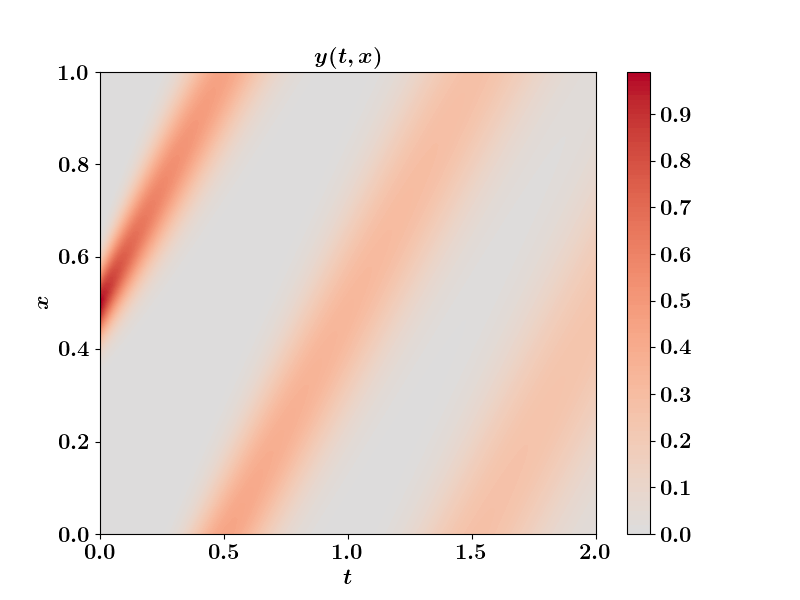

In [6]:
# ------------------------------------------------------
# --- Plot(t,x) ---
# ------------------------------------------------------
plot_tx(x, t, y, flag_simple=True)

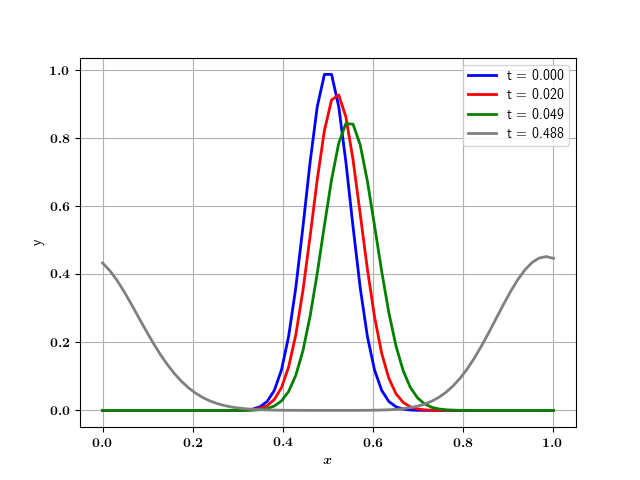

In [6]:
# ------------------------------------------------------------------
# --- Plotting the wave at various time moments ---
# ------------------------------------------------------------------
def plot_diff_time_moments(t_moments):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for it in range(len(t_moments)):
        id_t = t_moments[it]
        ax.plot(
            x, y[id_t, :], 
            color=colors_[it], linewidth = 2, linestyle='-',  
            label = "t = {:0.3f}".format(t[id_t])
        )
    plt.xlabel('$x$')
    plt.ylabel("y")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# ------------------------------------------------------------------
plot_diff_time_moments(t_moments = [0, 40, 100, 1000])

In [7]:
# --------------------------------------------------------
# --- LCHS python simulation ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
mix.reload_module(LCHS)

def computation_LCHS_py():
    t_LCHS = 0.1

    n_dk, coef_trot = 2, 100.0

    #      for n_dk = 0
    # *** nk = 4  --> kmax = 5 ***
    # *** nk = 5  --> kmax = 10 ***
    # *** nk = 6  --> kmax = 20 ***
    # *** nk = 7  --> kmax = 40 ***
    nk = 6 + n_dk

    # ---------------------
    Nk = 1<<nk
    
    print()
    print("LCHS-python computation: nk: ", nk)

    # dk = LCHS.get_dk(None, None, None, n_dk)
    dk = LCHS.get_dk(norm_Ah_, norm_Aa_, t_LCHS, n_dk)

    k_max_py = 0.5 * dk * (Nk - 1)
    k_grid = np.linspace(-k_max_py, k_max_py, Nk)
    print("dk, kmax: {:0.3e}, {:0.3f}".format(dk, k_max_py))

    # tau, N_steps = LCHS.get_trot(norm_Ah_, norm_Aa_, t_LCHS, coef_trot, k_max_py)
    # t_LCHS = tau * N_steps # correct the time moment for the LCHS

    N_steps = 1
    tau = t_LCHS / N_steps

    print("t, tau, N_steps: {:0.3e}, {:0.3e}, {:d}".format(t_LCHS, tau, N_steps))

    psi_LCHS_py = kvn.LCHS_computation(
        k_grid, tau,
        A_, psi_init, N_steps, 
        flag_trotterization = True, 
        flag_print = False
    )
    print("Done.")

    # --- Form a string to save data ---
    str_save_t = "t{:d}".format(int(10 * t_LCHS))
    str_save_pyLCHS = "kmax{:d}_dk{:d}".format(int(k_max_py), int(1000*dk))
    return psi_LCHS_py, t_LCHS, str_save_t, str_save_pyLCHS
# ------------------------------------------------------------------------

psi_LCHS_py_, t_LCHS_ , str_save_t_, str_save_pyLCHS_ = computation_LCHS_py()

# --- interpolate reference simulations ---
y_interp = np.zeros(Nx)
for ix in range(Nx):
    y_interp[ix] = np.interp(t_LCHS_, t, y[:,ix]) 

# --- maximum error ---
max_abs_err = np.max(np.abs(y_interp - psi_LCHS_py_))
max_rel_err = np.max(np.abs(y_interp - psi_LCHS_py_) / np.abs(y_interp))
print("max. abs. error: {:0.3e}".format(max_abs_err))
print("max. rel. error: {:0.3e}".format(max_rel_err))


LCHS-python computation: nk:  8
dk, kmax: 1.575e-01, 20.079
t, tau, N_steps: 1.000e-01, 1.000e-01, 1
Done.
max. abs. error: 5.121e-03
max. rel. error: 8.145e+08


In [68]:
# ----------------------------------------------------------
# --- SCANS: abs-err with respect to kmax for various dk ---
# ----------------------------------------------------------
def scan_kmax():
    def save_one(x, y, dk):
        str_dk = "dk{:d}".format(int(1000*dk))
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_scan_err_kmax_{:s}.dat".format(str_dk), 
            np.array(x), np.log10(np.array(y))
        )
        return
    # ------------------------------------------------------------------

    t = 1.9

    dk = 3.175e-01
    kmax_array    = [   10.000,    20.159,    40.476,    81.111]
    max_err_array = [2.027e-02, 1.507e-02, 1.261e-02, 1.176e-02]
    save_one(kmax_array, max_err_array, dk)

    dk = 1.575e-01
    kmax_array    = [   10.000,    20.079,    40.236,    80.551]
    max_err_array = [1.016e-02, 5.155e-03, 2.818e-03, 1.901e-03]
    save_one(kmax_array, max_err_array, dk)


    dk = 7.843e-02
    kmax_array    = [   10.000,    20.039,    40.118,    80.275]
    max_err_array = [9.925e-03, 4.773e-03, 2.528e-03, 1.506e-03]
    save_one(kmax_array, max_err_array, dk)
    return
# ------------------------------------------------------------------
scan_kmax()

write data to a file: ./jupyter-notebooks/NL/results//CDE_scan_err_kmax_dk317.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_scan_err_kmax_dk157.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_scan_err_kmax_dk78.dat


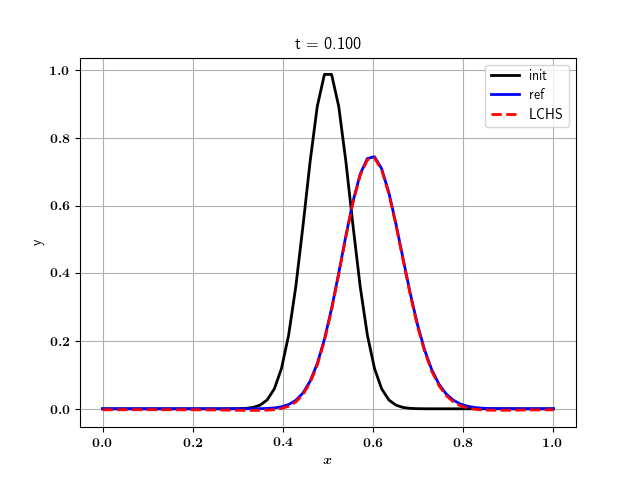

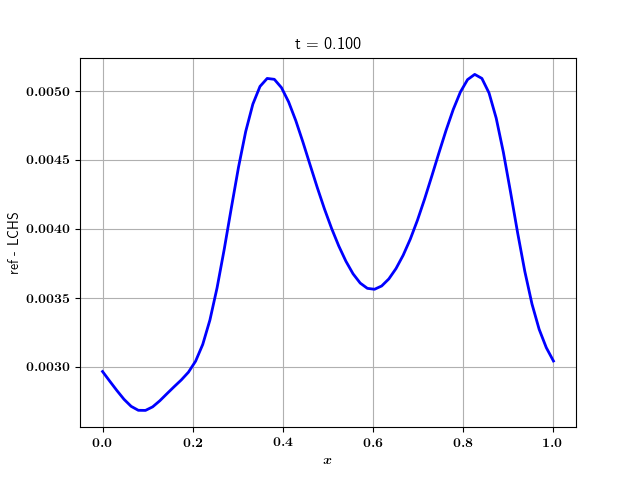

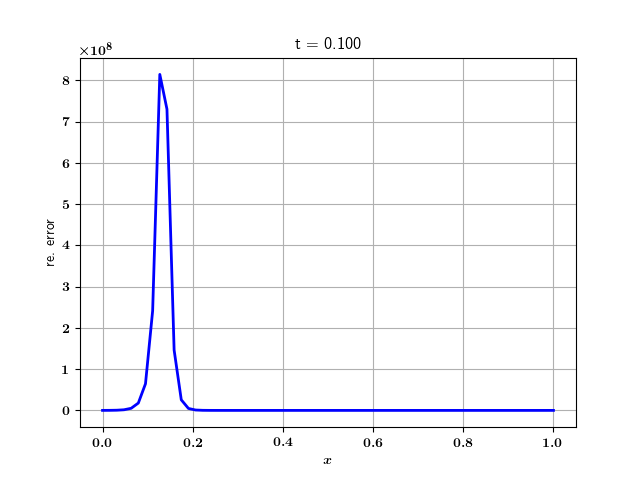

In [8]:
# --------------------------------------------------
# --- Compare reference and LCHS-py simulations  ---
# --------------------------------------------------
mix.reload_module(mix)
def compare_CL_LCHS_PY(flag_save):
    # --- Plotting signals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y[0,:],       "black",  linewidth = 2, label = "init")
    ax.plot(x, y_interp,     "-b",  linewidth = 2, label = "ref")
    ax.plot(x, psi_LCHS_py_.real, "--r", linewidth = 2, label = "LCHS")
    plt.xlabel('$x$')
    plt.ylabel("y")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting errors ---
    abs_err = y_interp - psi_LCHS_py_.real

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, abs_err, "-b",  linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("ref - LCHS")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    plt.grid(True)
    plt.show()

    # --- Plotting relative errors ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, np.abs(y_interp - psi_LCHS_py_)/np.abs(y_interp), "-b",  linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("re. error")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(path_save_ + "/CDE_init.dat", x, y[0,:])
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_CL_{:s}.dat".format(str_save_t_), 
            x, y_interp
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_PY_LCHS_{:s}_{:s}.dat".format(str_save_t_, str_save_pyLCHS_), 
            x, psi_LCHS_py_.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_PY_LCHS_ERR_{:s}_{:s}.dat".format(str_save_t_, str_save_pyLCHS_), 
            x, np.log10(np.abs(abs_err))
        )

    return
# -------------------------------------------------------------------
compare_CL_LCHS_PY(flag_save = False)

In [95]:
# ------------------------------------------------------------
# --- Initial parameters for the LCHS-QuCF simulation ---
# ------------------------------------------------------------

k_max_, nk_init_, n_dk_, coef_trot_ = 10, 5, 2, None     # dk = 1.575e-01
# k_max_, nk_init_, n_dk_, coef_trot_ = 20.079, 6, 2, None   # dk = 1.575e-01

# t_LCHS_qucf_, Nt_steps_ = 0.50, 10
# t_LCHS_qucf_, Nt_steps_ = 0.95, 20
# t_LCHS_qucf_, Nt_steps_ = 1.50, 30
t_LCHS_qucf_, Nt_steps_ = 1.90, 40
flag_AA_ = True

# --- Fourier k-grid ---
nk_ = nk_init_ + n_dk_
Nk_ = 1 << nk_
dk_ = LCHS.get_dk(None, None, None, n_dk=n_dk_)
k_max_ = 0.5 * dk_ * (Nk_ - 1)

# --- Path with the QuCF simulation ---
if D == 0.01:
    name_pr_ = "D001"
else:
    name_pr_ = None
    print("!!! ERROR: no QuCF simulations for D = {:0.3e}".format(D))

name_t_ = None
if t_LCHS_qucf_ == 0.50:  
    name_t_ = "t05"
if t_LCHS_qucf_ == 0.95:  
    name_t_ = "t095"
if t_LCHS_qucf_ == 1.5:  
    name_t_ = "t15"
if t_LCHS_qucf_ == 1.90:  
    name_t_ = "t19"
name_kmax_ = "kmax{:d}".format(int(k_max_))

name_pr_ += "_" + name_t_
name_pr_ += "_" + name_kmax_

path_root_ = "../QuCF/simulations/LCHS/DiffAdvEqu/"
path_qucf_ = path_root_ + "{:s}".format(name_pr_)

# --- Print parameters ---
print("Chosen parameters for the LCHS-QuCF simulation")
print("kmax, nk, dk:\t {:0.3f}, {:d}, {:0.3e}".format(k_max_, nk_, dk_))
if flag_AA_:
    print("with the AA of the LCHS weights")
else:
    print("without the AA of the LCHS weights")
print("LCHS-QuCF path:\t {:s}".format(path_qucf_))

Chosen parameters for the LCHS-QuCF simulation
kmax, nk, dk:	 10.000, 7, 1.575e-01
with the AA of the LCHS weights
LCHS-QuCF path:	 ../QuCF/simulations/LCHS/DiffAdvEqu/D001_t19_kmax10


In [96]:
# ------------------------------------------------------------
# --- Parameters for the BE ---
# ------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
def print_values(name_B, B, ir = 1):
    ic_l = ir - 1
    ic_r = ir + 1
    if ir == 0:
        ic_l = Nx - 1
    if ir == Nx - 1:
        ic_r = 0
    vl, vc, vr = B[ir, ic_l], B[ir, ir], B[ir, ic_r]
    print("{:s}: vl, vc, vr:\t {:20.3e}, {:20.3e}, {:20.3e}".format(name_B, vl, vc, vr))
    return
# -------------------------------------------------------------------------------
def compute_angles(name_B, B, d_vals, ir, flag_c):
    print("\n// --- BE: {:s} ---".format(name_B))
    ay_l, az_l = mix.calc_angles_from_a_value(B[ir, ir-1] / d_vals[0])
    ay_c, az_c = mix.calc_angles_from_a_value(B[ir, ir]   / d_vals[1])
    ay_r, az_r = mix.calc_angles_from_a_value(B[ir, ir+1] / d_vals[2])
    print("ay_{:s}_l  {:0.12e}".format(name_B, ay_l))
    if az_l is not None:
        print("az_{:s}_l  {:0.12e}".format(name_B, az_l))

    if flag_c:
        print("ay_{:s}_c  {:0.12e}".format(name_B, ay_c))
        if az_c is not None:
            print("az_{:s}_c  {:0.12e}".format(name_B, az_c))

    print("ay_{:s}_r  {:0.12e}".format(name_B, ay_r))
    if az_r is not None:
        print("az_{:s}_r  {:0.12e}".format(name_B, az_r))
    return
# -------------------------------------------------------------------------------
Ah_, Aa_ = mix.get_herm_aherm_parts(-A_) # !!!

Ba     = Aa_
B_kmax = - k_max_ * Ah_
Bk     =      dk_ * Ah_
Ba_norm,     ncoef_a,    nonsparsity_a    = mix.compute_normalized_matrix(Ba, "Ba", True, True)
B_kmax_norm, ncoef_kmax, nonsparsity_kmax = mix.compute_normalized_matrix(B_kmax, "B_kmax", True, True)
Bk_norm,     ncoef_k,    nonsparsity_k    = mix.compute_normalized_matrix(Bk, "Bk", True, True)
# mix.print_matrix(Ba_norm)
# mix.print_matrix(B_kmax_norm)
# mix.print_matrix(Bk_norm)

# --- Compute angles for the OH ---
ir_ch = 1
print_values("Ba-norm",   Ba_norm,     ir_ch)
print_values("Bmax-norm", B_kmax_norm, ir_ch)
print_values("Bk-norm",   Bk_norm,     ir_ch)

print("\n// --- Spatial resolution ---")
print("nx {:d}".format(nx))

compute_angles("Ba", Ba_norm,     [0.50, 0.50, 0.50], ir_ch, False)
compute_angles("Bm", B_kmax_norm, [0.25, 0.25, 0.50], ir_ch, True)

# mix.plot_structure_simple(Ba_norm, marker_size = 30)
# mix.plot_structure_simple(B_kmax_norm, marker_size = 30)
# kvn.plot_save_diagonals(Ba_norm, "Ah-norm", False, False, "")
# kvn.plot_save_diagonals(B_kmax_norm, "Ah-norm", False, False, "")

# --- Compute angles for the weights ---
print("\n//--- Angles for the weight-oracle ---")
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))

# --- Initialization --- 
print("\n//--- Initialization ---")
if flag_init_sin:
    alpha_init_0 = - 2.*np.pi
    alpha_init_1 = np.abs(alpha_init_0) * Nx/(Nx - 1)
else:
    alpha_init_0 = -0.5
    alpha_init_1 = 0.5 * Nx/(Nx - 1)

print("alpha_init_0 \t{:0.12e}".format(alpha_init_0))
print("alpha_init_1 \t{:0.12e}".format(alpha_init_1))

Matrix Ba:	 nonsparsity, coefnorm: 2, 8.910e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 4, 3.889e+03
Matrix Bk:	 nonsparsity, coefnorm: 4, 6.124e+01
Ba-norm: vl, vc, vr:	 0.000e+00-3.536e-01j, 0.000e+00+0.000e+00j, 0.000e+00+3.536e-01j
Bmax-norm: vl, vc, vr:	           -1.021e-01,            2.041e-01,           -1.021e-01
Bk-norm: vl, vc, vr:	            1.021e-01,           -2.041e-01,            1.021e-01

// --- Spatial resolution ---
nx 6

// --- BE: Ba ---
ay_Ba_l  1.570796326795e+00
az_Ba_l  3.141592653590e+00
ay_Ba_r  1.570796326795e+00
az_Ba_r  -3.141592653590e+00

// --- BE: Bm ---
ay_Bm_l  3.982661324158e+00
ay_Bm_c  1.230959417341e+00
ay_Bm_r  3.552730515912e+00

//--- Angles for the weight-oracle ---
nk 	7
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.007874015748e+00

//--- Initialization ---
alpha_init_0 	-5.000000000000e-01
alpha_init_1 	5.079365079365e-01


In [97]:
# ----------------------------------------------------------
# --- Trotterization steps ---
# ----------------------------------------------------------
def compute_trotterization_parameters(Nt_steps):
    tau_res = t_LCHS_qucf_/Nt_steps
    t_res = t_LCHS_qucf_

    # --- Normalized short-time intervals for the QSP circuits ---
    dt_a    = ncoef_a    * tau_res / 2.
    dt_kmax = ncoef_kmax * tau_res
    dt_k    = ncoef_k    * tau_res
    print("\n-----------------------------------------------")
    print("t = {:0.3e}".format(t_res))
    print("tau = {:0.3e}".format(tau_res))
    print("Nt\t {:d}".format(Nt_steps))
    print("dt_a, dt_kmax, dt_k: {:0.12e}, {:0.12e}, {:0.12e}".format(dt_a, dt_kmax, dt_k))
    return t_res, tau_res
# --------------------------------------------------
print("kmax = {:2.3f}".format(k_max_))
print("nk = {:d}".format(nk_))
print("dk = {:0.3e}".format(dk_))

t_qucf_final_, tau_qucf_ = compute_trotterization_parameters(Nt_steps = Nt_steps_)

# --- interpolate reference simulations ---
y_ref_compare_ = np.zeros(Nx)
for ix in range(Nx):
    y_ref_compare_[ix] = np.interp(t_qucf_final_, t, y[:,ix]) 

kmax = 10.000
nk = 7
dk = 1.575e-01

-----------------------------------------------
t = 1.900e+00
tau = 4.750e-02
Nt	 40
dt_a, dt_kmax, dt_k: 2.116017042701e+00, 1.847184709930e+02, 2.908952299103e+00



Reading the file ../QuCF/simulations/LCHS/DiffAdvEqu/D001_t19_kmax10/dc_OUTPUT.hdf5...
Name of the simulation is dc
Simulation has been performed  07-20-2024 19:44:22
A-max: 9.322808434669e-02
success prob: 1.906e-01
N-gates: 11309986
max-err, log: 1.020e-02, -1.991e+00


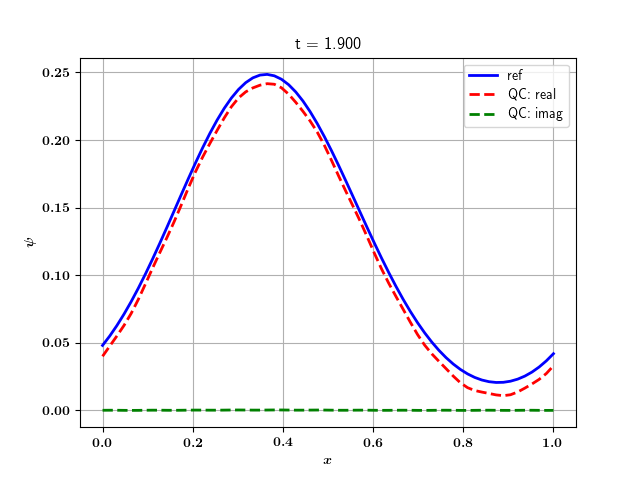

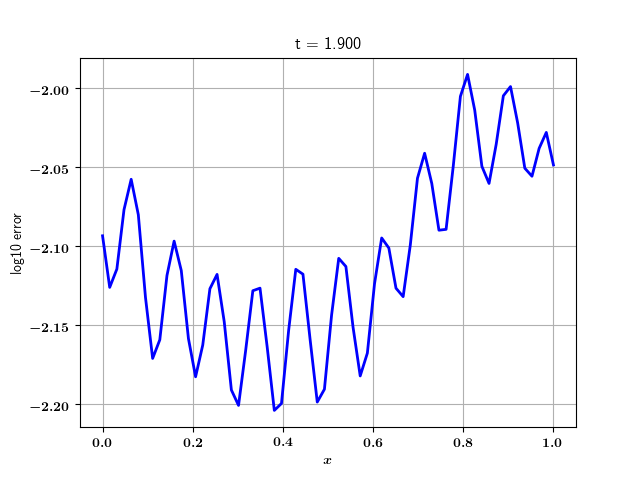

write data to a file: ./jupyter-notebooks/NL/results//CDE_CL_t19.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_QuCF_t19_kmax10.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_QuCF_err_t19_kmax10.dat


In [99]:
# --------------------------------------------------------
# --- Compare results with quantum simulations ---
# --------------------------------------------------------
def read_qc_data(path_qc, flag_init):
    print()  

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qc
    om.pname_ = "dc"
    om.open()
    
    # --- get the result ---
    Ngates = om.dd_["N-gates"]
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rx")
    
    print("A-max: {:0.12e}".format(np.max(np.abs(qc_state))))
    print("success prob: {:0.3e}".format(  np.sum(np.abs(qc_state)**2)  ))
    print("N-gates: {:d}".format(Ngates))

    # --- renormalization due to the initialization ---
    qc_state *= 2**(nx/2.)

    if not flag_init_sin:
        rr_init = None
        if int(nx) == 6 and width_init == 0.05:
            rr_init = 3.379733933513e+00
        qc_state /= rr_init

    # renormalization due to the influenc of the weights:
    if not flag_init:
        om.read_qsvt()
        Hadamart_norm_factor = 2**(nk_) 
        coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
        qc_state *= coef_norm * (dk_ / np.pi)

        if flag_AA_:
            rr_w = None # these coefficients are computed in calc-weights.ipynb
            if int(k_max_) == 10 and nk_ == 5:
                rr_w = 2.470306404836081
            if int(k_max_) == 10 and nk_ == 7: 
                rr_w = 2.420481578341e+00
            if int(k_max_) == 20 and nk_ == 8: 
                rr_w = 3.603260855413e+00
            if int(k_max_) == 40 and nk_ == 7: 
                rr_w = 5.092072717098e+00

            qc_state /= rr_w**2

    return qc_state
# ------------------------------------------------------------------------------
def compare_ref_qu(flag_init, flag_save, flag_plot):
    sign_qucf = 1.0
    if flag_init:
        sign_qucf = 1.0
        y_ref_ch = np.array(psi_init)
    else:
        y_ref_ch = np.array(y_ref_compare_)
    psi_qc = sign_qucf * read_qc_data(path_qucf_, flag_init)

    # psi_qc /= np.max(np.abs(psi_qc))
    # y_ref_ch /= np.max(np.abs(y_ref_ch))

    # --- Compute the absolute error ---
    err_res = np.abs(y_ref_ch - psi_qc.real)
    max_abs_err = np.max(np.abs(err_res))
    print("max-err, log: {:0.3e}, {:0.3e}".format(
        max_abs_err, np.log10(max_abs_err))
    )

    # --- Compare the quantum state and the reference simulation ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x, y_ref_ch,    "-b",  linewidth = 2, label = "ref")
        ax.plot(x, psi_qc.real, "--r", linewidth = 2, label = "QC: real")
        ax.plot(x, psi_qc.imag, "--g", linewidth = 2, label = "QC: imag")
        plt.xlabel('$x$')
        plt.ylabel("$\psi$")
        ax.legend()
        plt.title("t = {:0.3f}".format(t_LCHS_qucf_))
        plt.grid(True)
        plt.show()

        # --- Absolute error ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x, np.log10(err_res), "-b", linewidth = 2)
        plt.xlabel('$x$')
        plt.ylabel("log10 error")
        plt.title("t = {:0.3f}".format(t_LCHS_qucf_))
        plt.grid(True)
        plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_CL_{:s}.dat".format(name_t_), 
            x, y_ref_ch
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_QuCF_{:s}_{:s}.dat".format(name_t_, name_kmax_),  
            x, psi_qc.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_QuCF_err_{:s}_{:s}.dat".format(name_t_, name_kmax_), 
            x, np.log10(err_res)
        )
    return
# ------------------------------------------------------------------------------
compare_ref_qu(
    flag_init = False, # whether only the initialization circuit was simulated
    flag_save = True,
    flag_plot = True
)

In [61]:
# ----------------------------------------------------
# --- Scans ---
# ----------------------------------------------------
def scan_qucf():
    def save_one(kmax, x, y, str_data, flag_log = True):
        str_kmax = "kmax{:d}".format(int(kmax))

        y = np.array(y)
        if flag_log:
            y = np.log10(y)
        
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_QuCF_{:s}_{:s}.dat".format(str_kmax, str_data), 
            np.array(x), y
        )
        return
    # ------------------------------------------------------------------
    kmax = 10
    t_array       = [      0.5,      0.95,       1.5,       1.9]
    succ_prob_arr = [3.644e-01, 2.652e-01, 2.104e-01, 1.906e-01]
    Ngates_array  = [  2862326,   5670226,   8526046,  11309986]
    save_one(kmax, t_array, succ_prob_arr, "prob", flag_log = False)
    save_one(kmax, t_array, Ngates_array,    "Ng", flag_log = False)

    kmax = 20
    t_array       = [      0.5,      0.95,       1.5,       1.9]
    succ_prob_arr = [4.290e-01, 3.262e-01, 2.617e-01, 2.353e-01]
    Ngates_array  = [  5674856,  11248496,  16907656,  22438536]
    save_one(kmax, t_array, succ_prob_arr, "prob", flag_log = False)
    save_one(kmax, t_array, Ngates_array,    "Ng", flag_log = False)
    return
# ----------------------------------------------------
scan_qucf()

write data to a file: ./jupyter-notebooks/NL/results//CDE_QuCF_kmax10_prob.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_QuCF_kmax10_Ng.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_QuCF_kmax20_prob.dat
write data to a file: ./jupyter-notebooks/NL/results//CDE_QuCF_kmax20_Ng.dat


In [28]:
# ---------------------------------------------------------
# --- Compute rr_init for the amplitifed initialization ---
# ---------------------------------------------------------
def print_rr_init(line_str, A_ampl, A_non_ampl):
    rr = A_ampl / A_non_ampl
    print("{:s}:\t rr_init = {:0.12e}".format(line_str, rr))
    return
# ---------------------------------------------------------
print_rr_init("width = 0.05, nx = 6", 4.167608650991e-01, 1.233117379349e-01)

width = 0.05, nx = 6:	 rr_init = 3.379733933513e+00


In [ ]:
# ------------------------------------------------------------
# --- Check BE ---
# ------------------------------------------------------------
mix.reload_module(qucf_r)
mix.reload_module(mix)

# A_to_compare = Ba_norm
# A_to_compare = B_kmax_norm
A_to_compare = Bk_norm

dd_loc = qucf_r.read_matrix_sparse(path_qucf_, "dc_OUTPUT.hdf5") 
# dd_loc["A"].plot_structure("Matrix")
dd_loc["A"].is_the_same_as(mix.form_sparse_matrix(A_to_compare))

# print()
# mix.print_matrix(dd_loc["A"].form_dense_matrix())
# print()
# mix.print_matrix(A_to_compare)